In [ ]:
# Made by Premysl Pilar - A01760915
# This notebook shows how succesfull are cleaning agents using random movement
# 10/11/2022
# https://github.com/Mebillot/M1-Agents-Modelling/blob/main/CleaningAgents.ipynb

In [1]:
!pip install mesa

     ---------------------------------------- 1.8/1.8 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.5 MB/s eta 0:00:00
     -------------------------------------- 151.6/151.6 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 66.4/66.4 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 78.2/78.2 kB 2.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import mesa
import matplotlib.pyplot as plt
import numpy as np



In [23]:
# Cleaning agent cleans the dirt agent using wealth variable.
# When dirt agent is cleaned it will change its dirt to 0.
# Agents do not colide.
# Cleaning agents move randomly.

class CleaningAgent(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.dirt = 0

    def move(self):
        possible_steps = self.model.gridClean.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        if len(possible_steps) == 0:
            return
        new_position = self.random.choice(possible_steps)
        self.model.gridClean.move_agent(self, new_position)

    def clean(self):
        cleaned = False
        cellmates = self.model.gridDirt.get_cell_list_contents([self.pos])
        for i in cellmates:
            if i.dirt != 0:
                i.dirt = 0
                cleaned = True
        return cleaned

    # Agent can either clean or take a step
    def step(self):
        if not self.clean():
            self.move()
            
            
class DirtAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.dirt = 1
    def step(self):
        pass

In [24]:
# Model containing 2 grids one for each type of agents.
# Model makes sure that there is actual percentage of dirt on tiles, it does not allow multiple dirts on one tile.
class CleanModel(mesa.Model):
    #
    def __init__(self, numberOfCleaningAgents, percentageOfDirts, width, height):
        numberOfDirts =  int(height * width * percentageOfDirts / 100) 
        self.num_agents = numberOfCleaningAgents + numberOfDirts
        self.gridClean = mesa.space.MultiGrid(width, height, False)
        self.gridDirt = mesa.space.SingleGrid(width, height, False)
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(numberOfCleaningAgents):
            agent = CleaningAgent(i, self)
            self.schedule.add(agent)
            self.gridClean.place_agent(agent, (0, 0))

        for i in range(numberOfDirts):
            agent = DirtAgent(i+numberOfCleaningAgents, self)
            self.schedule.add(agent)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            while not self.gridDirt.is_cell_empty((x,y)):
                x = self.random.randrange(width)
                y = self.random.randrange(height)
            self.gridDirt.place_agent(agent,(x,y))
    def step(self):
        self.schedule.step()

In [141]:
# Given parameters
numberOfCleaningAgents = 10
percentageOfDirts=30
width=30
height=30
maxSteps = 100
sampleSize = 100
listIndividualStepsDirt = []
listPercentage = []
listSteps = []

In [121]:
# Function that initializes model with given parameters and performs the simulation
# Note it gathers the data of single steps by agents but since the tick should be "at once" it does not
# give any additional value and is calculated simply and not used further.
def testRun(locAgents = numberOfCleaningAgents,locPercen = percentageOfDirts,locWidth = width,locHeight = height, locSteps = maxSteps):
        model = CleanModel(locAgents,locPercen,locWidth,locHeight)
        totalSteps = 0
        totalAgentSteps = 0
        for i in range(locSteps):
            currentDirt = 0
            for agent in model.schedule.agents:
                currentDirt += agent.dirt
            actualDirtiness = 100 * currentDirt / (locHeight * locWidth)
            listIndividualStepsDirt.append(actualDirtiness)
            if currentDirt == 0:
                totalAgentSteps = i * locAgents
                listPercentage.append(actualDirtiness)
                listSteps.append(i)
                return
            model.step()
            if i == locSteps - 1:
                totalAgentSteps = locSteps * locAgents
                listPercentage.append(actualDirtiness)
                listSteps.append(locSteps)

In [144]:
# Prints histograms from the data obtained by the simulations.
def printHistograms():
    plt.hist(x=listPercentage, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.95)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Dirtiness')
    plt.ylabel('Frequency')
    plt.title('Percentages of dirty cells')
    plt.show()

    plt.hist(x=listSteps, bins= 'auto', color='#0504aa',
                                alpha=0.7, rwidth=0.95)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Steps')
    plt.ylabel('Frequency')
    plt.title('Number of steps taken')

    plt.show()
    
# Prints out the cleaning progress of individual run.
def printProgress():
    plt.plot(listIndividualStepsDirt)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Steps')
    plt.ylabel('Dirtiness')
    plt.title('Percentages of dirty cells')
    plt.show()
    
# Prints out end states of dirtiness and number of steps taken for changing parameters.  
def printScaling():
    plt.plot(listPercentage)
    plt.xlabel('Iteration')
    plt.ylabel('Dirtiness')
    plt.title('Percentages of dirty cells')
    plt.show()
    
    plt.plot(listSteps)
    plt.xlabel('Iteration')
    plt.ylabel('Steps')
    plt.title('Number of steps taken')
    plt.show()    

In [150]:
# Function that simulates the model *sampleSize* times, plots the histogram of dirtiness and 
# number of steps needed.
def batch(locAgents = numberOfCleaningAgents,locPercen = percentageOfDirts,locWidth = width,locHeight = height, locSteps = maxSteps,locSS = sampleSize):
    for test in range(locSS):
        testRun(locAgents,locPercen,locWidth,locHeight,locSteps)
    print("Test ended")
    printHistograms()

# Function that accepts initial parameters for model and then depending on scale parameter, increases input parameters each run
# Grid size is getting bigger by 1x1 and agents multilpy by 2 each run if set so.

def scalingBatch(locAgents = numberOfCleaningAgents,locPercen = percentageOfDirts,locWidth = width,locHeight = height, locSteps = maxSteps,locSS = sampleSize, agentScale = False, sizeScale = False):
    agentCoef = 1
    sizeAdd = 0
    if agentScale:
        agentCoef = 2
    if sizeScale:
        sizeAdd = 1
    for test in range(locSS):
        testRun(locAgents * agentCoef*test,locPercen,locWidth+(sizeAdd*test),locHeight+(sizeAdd*test),locSteps)
    print("Test ended")
    printScaling()

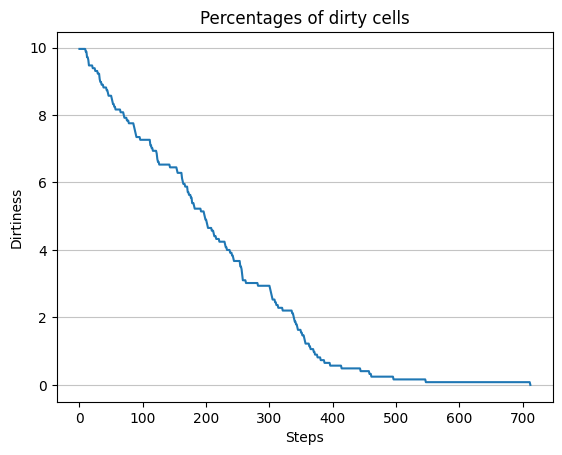

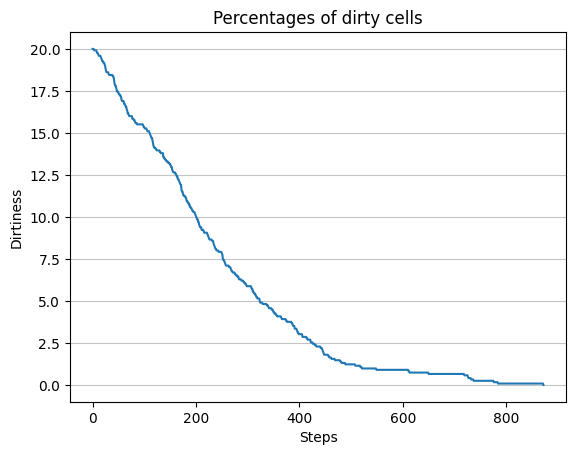

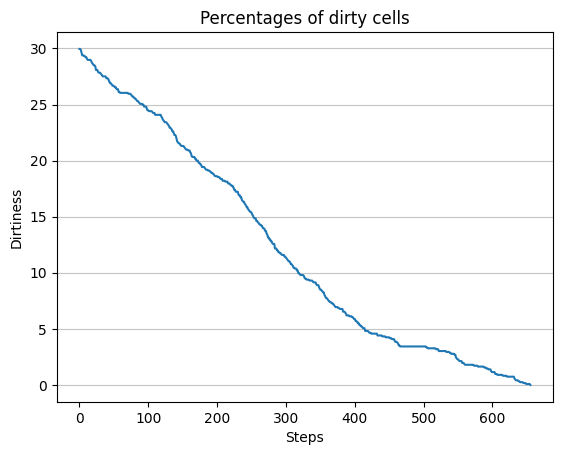

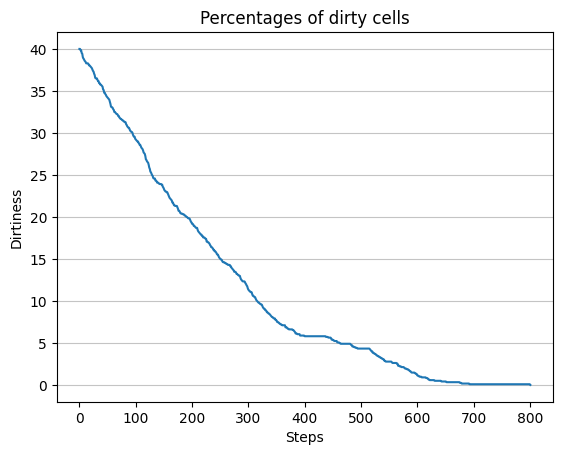

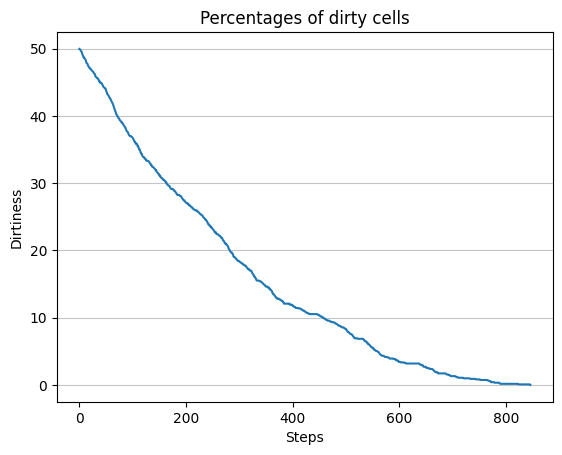

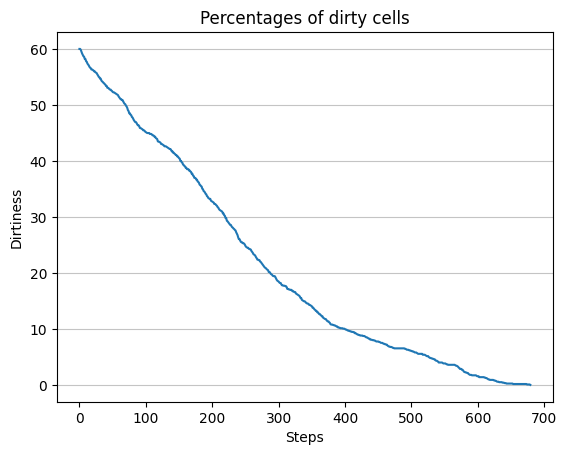

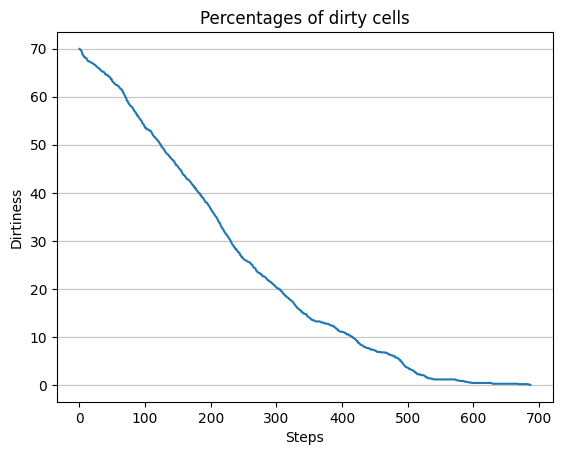

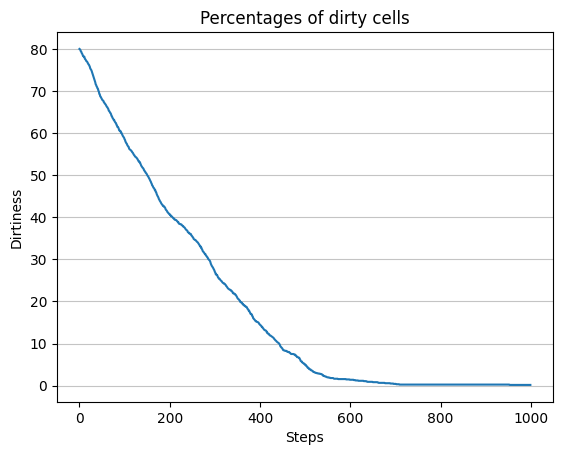

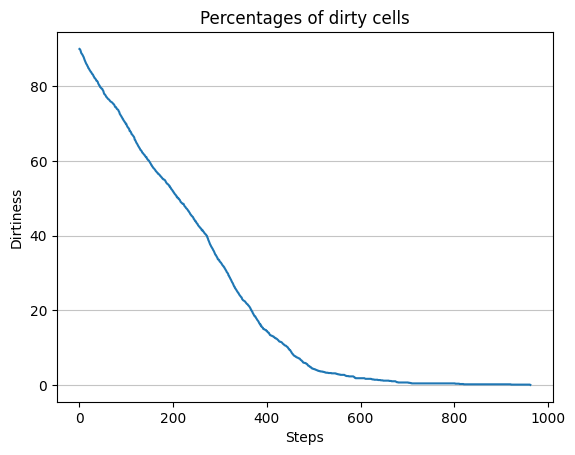

In [126]:
# Let us see how the density of dirty cells affects the speed of cleaning.
for i in range(1,10):
    listIndividualStepsDirt = []
    testRun(50,10*i,35,35,1000)
    printProgress()

Above we could see that with even with more dirty cells the number of steps did not change significally.
Even though graphs may look similar the Y scale is different. That mean that with bigger density the quicker the decrease
is in the beggining.
Graphs can lead us to assumption that for big enough cases the process of discovering the whole grid is the real task.
It follows exponentional decay curve.

Test ended


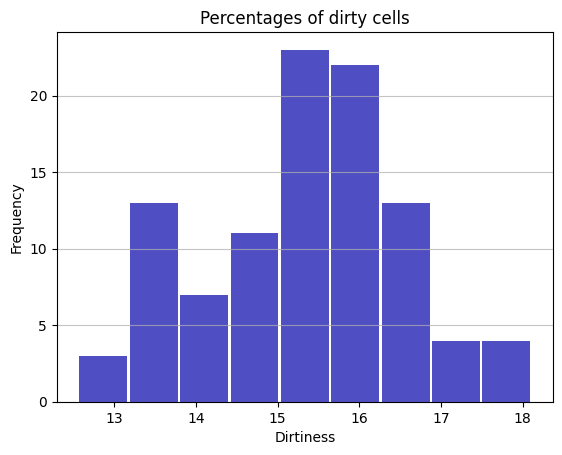

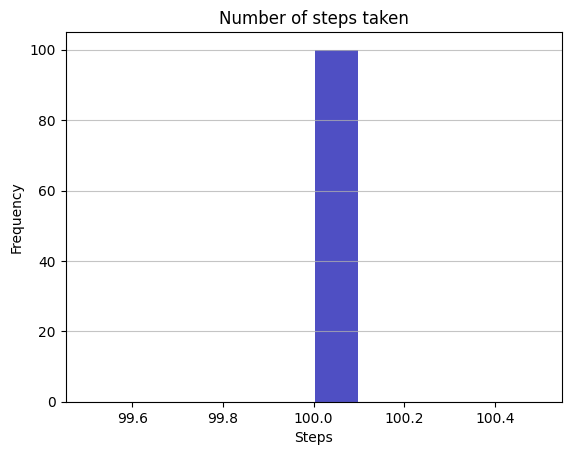

In [127]:
# Now let's see how the random movement affects the results
listIndividualStepsDirt = []
listPercentage = []
listSteps = []
batch(200)

As we can see our agents could not complete the cleaning here. By given paramaters it was impossible the cover whole plane.
On the dirtiness graph we can clearly see that the random movement follows normal distribution.

Test ended


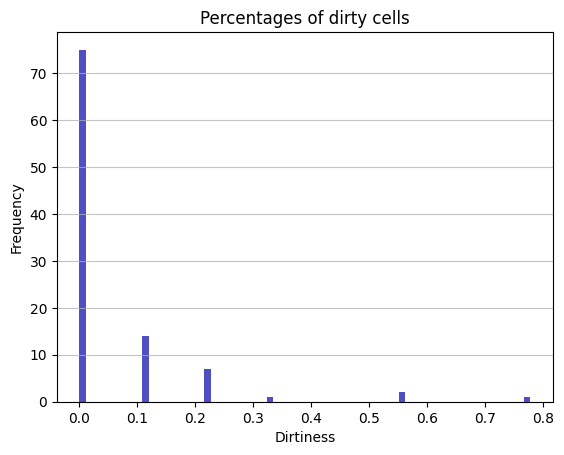

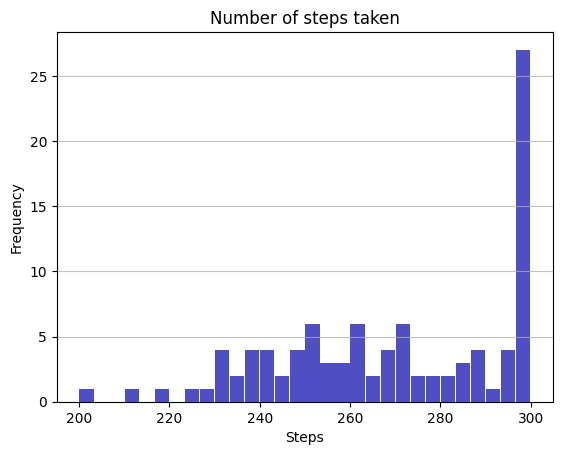

In [131]:
# Now let's increase number of agents and maximum steps.
numberOfCleaningAgents = 500
maxSteps = 300
listPercentage = []
listSteps = []
listIndividualStepsDirt = []

batch(locSteps = maxSteps, locAgents = numberOfCleaningAgents, locWidth = width, locHeight = height, locSS = sampleSize)

We can see that now the model is able to clean the grid in time. Number of steps taken is also 
following normal distribution. If it would clean it everytime it would not have the spike on the right.
The spike on the right is cumulation of all models that could not finish the cleaning in time.



Test ended


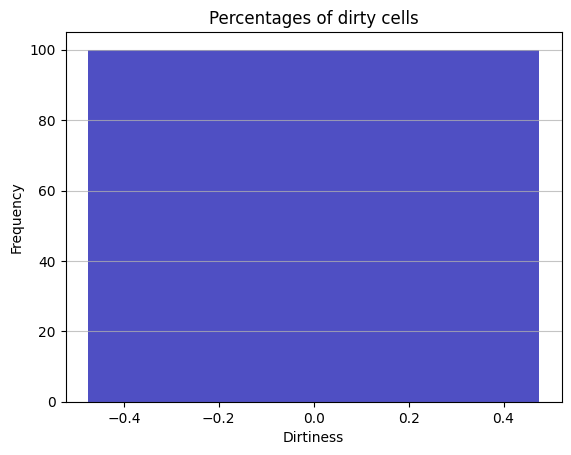

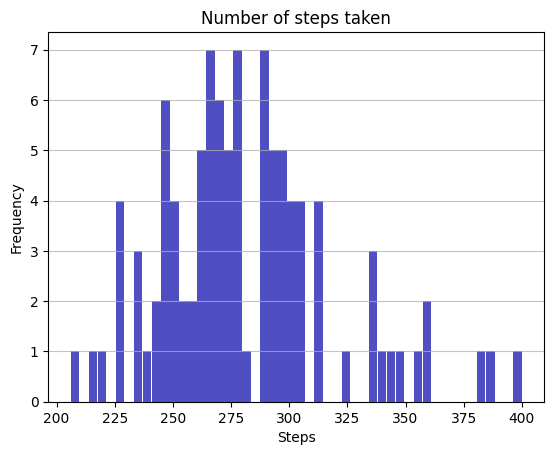

In [134]:
#Let's remove the spike
maxSteps = 500
listPercentage = []
listSteps = []
batch(locSteps = maxSteps, locAgents = numberOfCleaningAgents, locWidth = width, locHeight = height, locSS = sampleSize)

Test ended


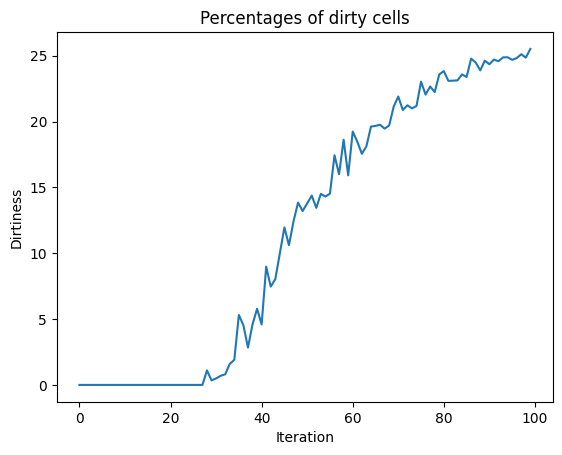

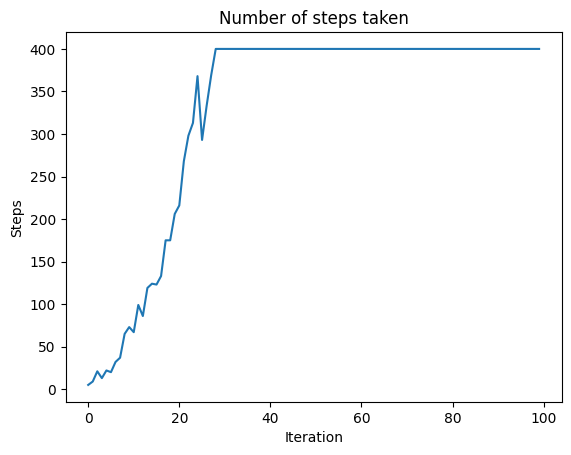

In [147]:
#Let's increase the number of agent and maximum number of steps
numberOfCleaningAgents = 200
maxSteps = 400
listPercentage = []
listSteps = []
scalingBatch(locSteps = maxSteps, locAgents = numberOfCleaningAgents, locWidth = 5, locHeight = 5, locSS = sampleSize,sizeScale = True)

Number of steps exponentionally increases. Every tile of space increases difficulty of the task.
The final dirtiness also increases after it cannot be done in time. That is to be expected since the agents need to cover
larger space to be able to clean it. Also it is good to make a note that number of dirty cells also increases since we 
are working with percentage. The agent must stop for one turn to clean, that decreases their efficiency to actually search
space.

Test ended


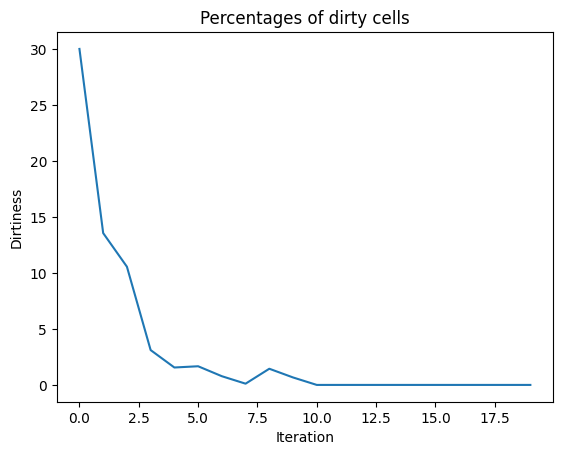

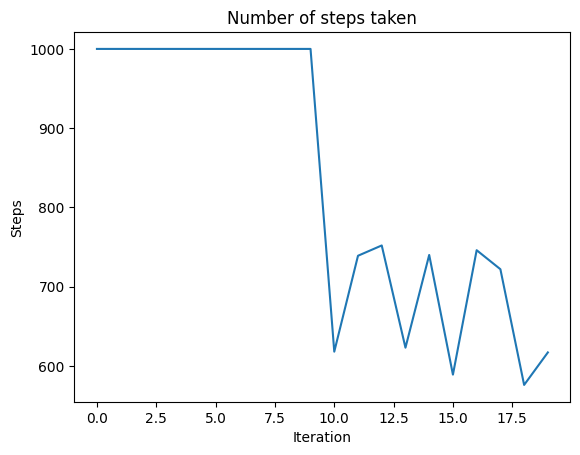

In [153]:
listPercentage = []
listSteps = []
scalingBatch(locSteps = 1000, locAgents = 1, locWidth = 30, locHeight = 30, locSS = 20,agentScale = True)

We can see the exponentional decrease in dirtiness as the iteration goes on. We multiplied the number of agents by 2 each
time. The graph might have been more linear if we were just adding fixed amount of agents but in the bigger scale it would look like this again. For steps taken... well the result is interesting, I suppose the randomness really hit hard here.
Let's say that with oscilation it is decreasing in linear manner.


And we could play like this for forever. The random movement is not the best choice to solve to problem but with a brute strength it can solve it. Since the movements are randomly chosen without any seed the results will differ every run. To further investigate the influence of each parameter we would need to introduce such a thing. And yet we could continue with the analysis. Simply more agents and more maximum steps better cleaning power. Bigger space and more dirt tiles less cleaning power. For the number of steps if the cleaning power was enough we can see normal distribution. For Dirtiness we can see the normal distribution as well. Of course we could change the parameters more but for task this simple I think it is not that much beneficial anymore.

Note: The influence of shape of the grid was not investigated and only square shape was used. Interesting case would be one dimensional grid. We could see try to sample probability since we would randomly do only left or right and the chance to reach further tiles would decrease.